# ML workshop
01/06/2020

## Bootstrap
Before we get started, ensure you have your machine setup. Here I am using Python 3 with `pip` (not conda):

```sh
python3 -m venv ml-env
. ml-env/bin/activate  # Windows: > ml-env\Scripts\activate
pip install -U pip
pip install -U setuptools wheel
pip install jupyter
jupyter notebook  # Opens an interactive web interface; then you should File⇒New Notebook.
# Feel free to run `ipython`—or `python`—instead, and work just on the CLI.
```

Alternatively, follow one of these links to run it in a cloud environment:

| Google | Microsoft | Open-source |
|--------|-----------|-------------|
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/offscale/offscale-presentations/blob/master/ml_workshop-01-06-2020.ipynb) | [![Azure Notebooks](https://notebooks.azure.com/launch.svg)](https://docs.microsoft.com/en-us/azure/notebooks/quickstart-clone-jupyter-notebook) | [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/offscale/offscale-presentations/master?filepath=ml_workshop-01-06-2020.ipynb) |

In [1]:
#!pip install jupyter matplotlib tensorflow tensorflow_datasets jax jaxlib torch torchvision scikit-learn
# Some of the hosted Jupyter Notebook don't auto find and install dependencies via imports, so we do it explicitly^
# Ensure you uncomment that top line in those environments, otherwise you'll get `ImportError`s.

## What is machine-learning and artificial-intelligence?

## What's a neural network (NN), and what's a convolutional neural network (CNN)?

### Convolution
> A convolution is an integral that expresses the amount of overlap of one function $g$ as it is shifted over another function $f$. 
![Convolution visualisation](https://mathworld.wolfram.com/images/gifs/convgaus.gif)
https://mathworld.wolfram.com/Convolution.html

In [2]:
from tempfile import gettempdir
from os import path

from IPython.display import display, IFrame

display(
    IFrame(
        "https://docs.google.com/viewerng/viewer?url={url}&embedded=true".format(
            url="https://github.com/brohrer/public-hosting/raw/master/How_CNNs_work.pdf"
        ),
        height="475px",
        width="100%",
    )
)

## Why should I care?

## How do I ML?

There are some popular offerrings, of which I'll go through 4 today:
- TensorFlow (Google)
- JAX (Google)
- PyTorch (Facebook)
- scikit.learn (David Cournapeau then INRIA)

|                                          | License      | CPU | GPU | TPU | Web | Mobile |
|------------------------------------------|--------------|-----|-----|-----|-----|--------|
| [JAX](https://jax.readthedocs.io)        | Apache-2.0   | ✔   | ✔   | ✔   | ✔   | ✔      |
| [TensorFlow](https://www.tensorflow.org) | Apache-2.0   | ✔   | ✔   | ✔   | ✔   | ✔      |
| [PyTorch](https://pytorch.org)           | BSD 3-Clause | ✔   | ✔   | ✔   | ✘*  | ✔      |
| [scikit.learn](https://scikit-learn.org) | New BSD      | ✔   | ✘   | ✘   | ✘†  | ✘‡     |

*Efforts to port to WASM, through another language: https://github.com/sinkingsugar/nimtorch

†Efforts to port to WASM: https://github.com/iodide-project/pyodide

‡Nothing built into the framework, but using third-party libraries you can.

# MNIST
Very popular dataset in the machine-learning sphere, with the goal of figuring out from an image which arabic numeral it is.

![https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Visualisation (3D, drag and right-clik): https://www.cs.ryerson.ca/~aharley/vis/

Node/math based: https://jalammar.github.io/visual-interactive-guide-basics-neural-networks https://jalammar.github.io/feedforward-neural-networks-visual-interactive

Input nodes, hidden nodes, output nodes: http://nn-mnist.sennabaum.com/


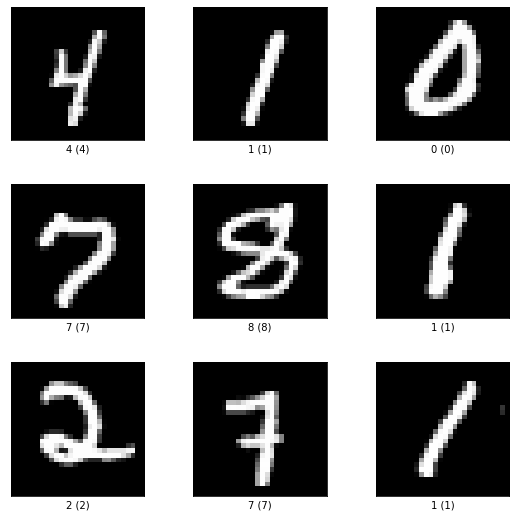

In [3]:
# Let's load in the dataset. This will be used for JAX and TensorFlow examples.
# (Although `as_numpy` would work fine with PyTorch, we want to use their recommended setup.)

import tensorflow_datasets as tfds

data_dir = path.join(gettempdir(), "tfds")

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, mnist_info = tfds.load(
    name="mnist", batch_size=-1, data_dir=data_dir, with_info=True
)
_ = tfds.show_examples(
    *tfds.load("mnist", split="train", with_info=True, data_dir=mnist_info.data_dir)
)

In [4]:
mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [5]:
def globals_helper(k):
    globals_helper.i += 1

    return k if isinstance(k, (type(None), dict, float, int, list, set, str)) else None


globals_helper.i = 0
globals_before_jax = frozenset(filter(None, map(globals_helper, globals())))
globals_i_before_jax = globals_helper.i
globals_helper.i = 0

# JAX
![JAX](https://raw.githubusercontent.com/google/jax/master/images/jax_logo_250px.png)
Think of it as numpy but for GPUs and TPUs. It is very focussed on composability.
> It can differentiate through loops, branches, recursion, and closures, and it can take derivatives of derivatives of derivatives. It supports reverse-mode differentiation (a.k.a. backpropagation) via grad as well as forward-mode differentiation, and the two can be composed arbitrarily to any order.

Ref: The next are based off the [official Apache-2.0 licensed notebook by JAX](https://github.com/google/jax/blob/b6777c0/docs/notebooks/neural_network_with_tfds_data.ipynb)

In [6]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp

### Hyperparameters
Let's get a few bookkeeping items out of the way.

In [7]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))


# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [
        random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)
    ]


layer_sizes = [784, 512, 512, 10]
param_scale = 0.1
step_size = 0.01
batch_size = 128
n_targets = 10

### Auto-batching predictions

Let us first define our prediction function. Note that we're defining this for a _single_ image example. We then use JAX's `vmap` function to automatically handle mini-batches, with no performance penalty.

In [8]:
def relu(x):
    return np.maximum(0, x)


def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)


batched_predict = vmap(predict, in_axes=(None, 0))

### Utility and loss functions

In [9]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def accuracy(params, images, targets):
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(batched_predict(params, images), axis=1)
    return np.mean(predicted_class == target_class)


def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -np.mean(preds * targets)


@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return [
        (w - step_size * dw, b - step_size * db)
        for (w, b), (dw, db) in zip(params, grads)
    ]

### Data Loading with `tensorflow/datasets`

JAX is laser-focused on program transformations and accelerator-backed NumPy, so we don't include data loading or munging in the JAX library. There are already a lot of great data loaders out there, so let's just use them instead of reinventing anything. We'll use the `tensorflow/datasets` data loader.

In [10]:
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data["train"], mnist_data["test"]
num_labels = mnist_info.features["label"].num_classes
h, w, c = mnist_info.features["image"].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data["image"], train_data["label"]
train_images = np.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data["image"], test_data["label"]
test_images = np.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

/Users/samuel/repos/.venvs_py3/ml-env/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [11]:
print(
    "Train:".ljust(6),
    train_images.shape,
    train_labels.shape,
    "\nTest:".ljust(7),
    test_images.shape,
    test_labels.shape,
)

Train: (60000, 784) (60000, 10) 
Test:  (10000, 784) (10000, 10)


### Training Loop

In [12]:
import time


def get_train_batches():
    # as_supervised=True gives us the (image, label) as a tuple instead of a dict
    ds = tfds.load(name="mnist", split="train", as_supervised=True, data_dir=data_dir)
    # You can build up an arbitrary tf.data input pipeline
    ds = ds.batch(batch_size).prefetch(1)
    # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
    return tfds.as_numpy(ds)


def train(num_epochs, callbacks):
    params = init_network_params(layer_sizes, random.PRNGKey(0))
    for epoch in range(num_epochs):
        start_time = time.time()
        for x, y in get_train_batches():
            x = np.reshape(x, (len(x), num_pixels))
            y = one_hot(y, num_labels)
            params = update(params, x, y)
        epoch_time = time.time() - start_time

        train_acc = accuracy(params, train_images, train_labels)
        test_acc = accuracy(params, test_images, test_labels)
        for callback in callbacks:
            callback(**locals())

In [13]:
print_callback = (
    lambda epoch, epoch_time, num_epochs, train_acc, test_acc, **_kwargs: print(
        "Epoch {epoch} in {epoch_time:0.2f} sec\n"
        "Training set accuracy {train_acc:>10}\n"
        "Test set accuracy {test_acc:>22}{maybe_nl}".format(
            epoch=epoch,
            epoch_time=epoch_time,
            train_acc=format(float(train_acc), "01.16f"),
            test_acc=format(float(test_acc), "01.16f"),
            maybe_nl="\n" if num_epochs > epoch + 1 else "",
        )
    )
)

In [14]:
train(num_epochs=10, callbacks=(print_callback,))

Epoch 0 in 5.98 sec
Training set accuracy 0.9253333210945129
Test set accuracy     0.9272000193595886

Epoch 1 in 4.58 sec
Training set accuracy 0.9428166747093201
Test set accuracy     0.9413999915122986

Epoch 2 in 4.54 sec
Training set accuracy 0.9532666802406311
Test set accuracy     0.9516999721527100

Epoch 3 in 5.39 sec
Training set accuracy 0.9599499702453613
Test set accuracy     0.9552999734878540

Epoch 4 in 6.37 sec
Training set accuracy 0.9652333259582520
Test set accuracy     0.9603999853134155

Epoch 5 in 6.08 sec
Training set accuracy 0.9691500067710876
Test set accuracy     0.9631000161170959

Epoch 6 in 4.92 sec
Training set accuracy 0.9726166725158691
Test set accuracy     0.9653000235557556

Epoch 7 in 5.24 sec
Training set accuracy 0.9754499793052673
Test set accuracy     0.9666000008583069

Epoch 8 in 5.28 sec
Training set accuracy 0.9779833555221558
Test set accuracy     0.9682000279426575

Epoch 9 in 4.89 sec
Training set accuracy 0.9802833199501038
Test set acc

We've now used the whole of the JAX API: `grad` for derivatives, `jit` for speedups and `vmap` for auto-vectorization.
We used NumPy to specify all of our computation, and borrowed the great data loaders from `tensorflow/datasets`, and ran the whole thing on either the CPU, GPU, or TPU.

In [15]:
globals_before_tensorflow = frozenset(filter(None, map(globals_helper, globals())))
globals_i_before_tensorflow = globals_helper.i
globals_helper.i = 0
print(
    "JAX introduced", globals_i_before_tensorflow - globals_i_before_jax, "new symbols"
)

JAX introduced 47 new symbols


![TensorFlow](https://www.gstatic.com/devrel-devsite/prod/vf4ca28c48392b1412e7b030290622a0dd55b62dec1202c59f119b1e23227c988/tensorflow/images/lockup.svg)
> TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

Ref: The next are based off the [official Apache-2.0 licensed notebook by TensorFlow](https://github.com/tensorflow/datasets/blob/8723d84/docs/keras_example.ipynb)

In [16]:
import tensorflow as tf

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir=data_dir,
)

In [17]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label


ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"],
)

In [20]:
model.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3556 - accuracy: 0.9028 - val_loss: 0.2012 - val_accuracy: 0.9407
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1640 - accuracy: 0.9527 - val_loss: 0.1356 - val_accuracy: 0.9600
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.1179 - accuracy: 0.9661 - val_loss: 0.1119 - val_accuracy: 0.9664
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0915 - accuracy: 0.9734 - val_loss: 0.1097 - val_accuracy: 0.9674
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0740 - accuracy: 0.9788 - val_loss: 0.0909 - val_accuracy: 0.9722
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0613 - accuracy: 0.9823 - val_loss: 0.0863 - val_accuracy: 0.9736
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0513 - accuracy: 0.9854 - val_loss: 0.0794 - val_accuracy: 0.9763
Epoch 

In [21]:
globals_before_pytorch = frozenset(filter(None, map(globals_helper, globals())))
globals_i_before_pytorch = globals_helper.i
globals_helper.i = 0
print(
    "TensorFlow introduced",
    globals_i_before_pytorch - globals_i_before_tensorflow,
    "new symbols",
)

TensorFlow introduced 15 new symbols


![PyTorch](https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.png)
> An open source machine learning framework that accelerates the path from research prototyping to production deployment.

Ref: The next are based off the [official BSD 3-Clause example by PyTorch](https://github.com/google/jax/blob/b6777c0/docs/notebooks/neural_network_with_tfds_data.ipynb)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [24]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 25 == 0:
            print(
                "Train Epoch: {epoch} [{batch}/{train_loader_n:} ({pc:.0f}%)]".format(
                    epoch=epoch,
                    batch=batch_idx * len(data),
                    train_loader_n=len(train_loader.dataset),
                    pc=100.0 * batch_idx / len(train_loader),
                ),
                "Loss: {loss:.6f}".ljust(35).format(loss=loss.item()),
            )

In [25]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{test_loader_n} ({pc:.0f}%)\n".format(
            test_loss=test_loss,
            correct=correct,
            test_loader_n=len(test_loader.dataset),
            pc=100.0 * correct / len(test_loader.dataset),
        )
    )

In [26]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        data_dir,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        data_dir,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

In [27]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)] Loss: 2.293000                   
Train Epoch: 1 [3200/60000 (5%)] Loss: 0.629171                   
Train Epoch: 1 [6400/60000 (11%)] Loss: 0.426245                   
Train Epoch: 1 [9600/60000 (16%)] Loss: 0.245386                   
Train Epoch: 1 [12800/60000 (21%)] Loss: 0.139739                   
Train Epoch: 1 [16000/60000 (27%)] Loss: 0.225497                   
Train Epoch: 1 [19200/60000 (32%)] Loss: 0.162955                   
Train Epoch: 1 [22400/60000 (37%)] Loss: 0.190514                   
Train Epoch: 1 [25600/60000 (43%)] Loss: 0.187234                   
Train Epoch: 1 [28800/60000 (48%)] Loss: 0.202223                   
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.078650                   
Train Epoch: 1 [35200/60000 (59%)] Loss: 0.115532                   
Train Epoch: 1 [38400/60000 (64%)] Loss: 0.187219                   
Train Epoch: 1 [41600/60000 (69%)] Loss: 0.092489                   
Train Epoch: 1 [44800/60000 (75%)] Loss: 0.

Train Epoch: 7 [3200/60000 (5%)] Loss: 0.003926                   
Train Epoch: 7 [6400/60000 (11%)] Loss: 0.021495                   
Train Epoch: 7 [9600/60000 (16%)] Loss: 0.067986                   
Train Epoch: 7 [12800/60000 (21%)] Loss: 0.040834                   
Train Epoch: 7 [16000/60000 (27%)] Loss: 0.009835                   
Train Epoch: 7 [19200/60000 (32%)] Loss: 0.032620                   
Train Epoch: 7 [22400/60000 (37%)] Loss: 0.029635                   
Train Epoch: 7 [25600/60000 (43%)] Loss: 0.018652                   
Train Epoch: 7 [28800/60000 (48%)] Loss: 0.012598                   
Train Epoch: 7 [32000/60000 (53%)] Loss: 0.042428                   
Train Epoch: 7 [35200/60000 (59%)] Loss: 0.023380                   
Train Epoch: 7 [38400/60000 (64%)] Loss: 0.024325                   
Train Epoch: 7 [41600/60000 (69%)] Loss: 0.025021                   
Train Epoch: 7 [44800/60000 (75%)] Loss: 0.020271                   
Train Epoch: 7 [48000/60000 (80%)] Los

In [28]:
globals_before_scikit_learn = frozenset(filter(None, map(globals_helper, globals())))
globals_i_before_scikit_learn = globals_helper.i
globals_helper.i = 0
print(
    "TensorFlow introduced",
    globals_i_before_scikit_learn - globals_i_before_tensorflow,
    "new symbols",
)

TensorFlow introduced 41 new symbols


![scikit.learn](https://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)
> Built on NumPy, SciPy, and matplotlib.

Ref: The next are based off the [official BSD licensed Python code by scikit.learn](https://scikit-learn.org/stable/_downloads/9b3be64651591413a73d3848e0317ffd/plot_mnist_filters.py)

In [29]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

In [30]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, data_home=data_dir)
X = X / 255.0

In [31]:
# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [32]:
mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    alpha=1e-4,
    max_iter=55,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.1,
)

mlp.fit(X_train, y_train)

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
Iteration 11, loss = 0.04082169
Iteration 12, loss = 0.03828222
Iteration 13, loss = 0.03557957
Iteration 14, loss = 0.03054891
Iteration 15, loss = 0.02924761
Iteration 16, loss = 0.02610471
Iteration 17, loss = 0.02363894
Iteration 18, loss = 0.02208186
Iteration 19, loss = 0.01932900
Iteration 20, loss = 0.01830387
Iteration 21, loss = 0.01639227
Iteration 22, loss = 0.01392950
Iteration 23, loss = 0.01270193
Iteration 24, loss = 0.01234102
Iteration 25, loss = 0.01081313
Iteration 26, loss = 0.01028644
Iteration 27, loss = 0.00896707
Iteration 28, loss = 0.00744908
Iteration 29, loss = 0.00707946
Iteration 30, loss = 0.00573869
Iteration 31, loss = 0.00499554
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=55,
              random_state=1, solver='sgd', verbose=10)

In [33]:
print(
    "Training set score: {training_set_score:>3}\n"
    "Test set score: {test_set_score:>10}".format(
        training_set_score=mlp.score(X_train, y_train),
        test_set_score=mlp.score(X_test, y_test),
    )
)

Training set score: 1.0
Test set score:     0.9731


In [34]:
globals_now = frozenset(filter(None, map(globals_helper, globals())))
globals_i_now = globals_helper.i
globals_helper.i = 0
print(
    "scikit.learn introduced",
    globals_i_now - globals_i_before_scikit_learn,
    "new symbols",
)

scikit.learn introduced 20 new symbols
